In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/home/mila/l/leo.gagnon/latent_control')

from wandb import Api
import pandas as pd
from task import MetaLearningTask
import seaborn as sns
import torch
from models.gpt import GPT
from models.mamba import MambaLMHeadModel

/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/mamba_ssm/ops/selective_scan_interface.py:164: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, xz, conv1d_weight, conv1d_bias, x_proj_weight, delta_proj_weight,
/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/mamba_ssm/ops/selective_scan_interface.py:240: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, dout):
/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/mamba_ssm/ops/triton/layer_norm.py:986: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(
/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/mamba_ssm/ops/triton/layer_nor

# Prequential stuff

In [2]:
runs = Api().runs(
    path="leogagnon/latent_control",
    filters={
        "$or": [
            {"config.sweep_id": "5M_2024-10-27-17-19-46"},
        ]
    },
)
runs = [run.id for run in runs]

df = pd.DataFrame(
    columns=[
        "method",
        "model",
        "seed",
        "seq_id",
        "n_samples",
        "f_kl",
        "b_kl",
        "nll",
    ]
)

N_RUNS = 128
C_LEN = 150

# Hardcoded this part cuz made an error in checkpointing

for id in runs:
    task = MetaLearningTask(id).cuda()
    task: MetaLearningTask
    if task.cfg.data.context_length == [50, 50]:
        method = 'short'
    elif task.cfg.data.context_length == [100, 100]:
        method = 'long'
    else:
        continue
    
    model = "GPT" if isinstance(task.model, GPT) else "Mamba"

    pp_dict = task.evaluate_pp(N_RUNS, C_LEN + 1, 4)

    for i in range(N_RUNS):
        for j in range(C_LEN):
            df.loc[len(df)] = {
                "method": method,
                "model": model,
                "seed": task.cfg.data.seed,
                "seq_id": i,
                "n_samples": j,
                "f_kl": pp_dict["ForwardKL"][i, j].item(),
                "b_kl": pp_dict["BackwardKL"][i, j].item(),
                "nll": pp_dict["ModelNLL"][i, j].item(),
            }

df.to_csv("5M.csv")

number of parameters: 4.75M
Loaded dataset : (11288/1000)
Loaded checkpoing : epoch=894,step=40250.ckpt
number of parameters: 4.59M
Loaded dataset : (11288/1000)
Loaded checkpoing : epoch=894,step=40250.ckpt


In [2]:
df = pd.read_csv('prequential_mamba_controlled.csv')

/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/mila/l/leo.gagnon/latent_control/venv/lib/python3.10/site-p

<Axes: xlabel='n_samples', ylabel='f_kl'>

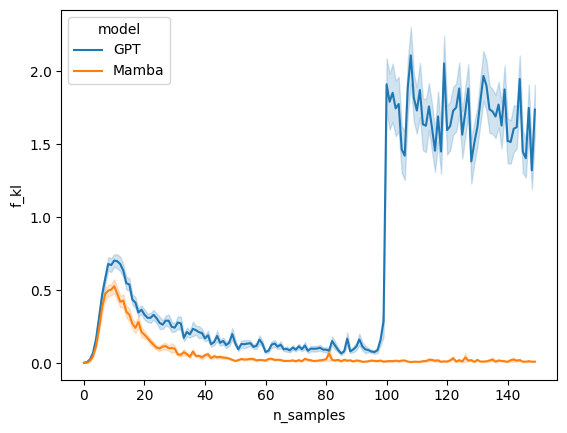

In [6]:
sns.lineplot(df, x='n_samples', y='f_kl', hue='model', errorbar=('se',1.0))